# Assignment 1

We load all packages here. We have included a `requirements.txt` file in the folder, showing which package-versions we use to have the script run. 

In [1]:
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt 
plt.rcParams["font.family"] = "Georgia"
import calplot
import plotly.express as px
import requests
import seaborn as sns

## A1 Part 1: Visualizing patterns in the data

In this sub-assignment, we recreate some of the plots from Week 2. We look only at the focus-crimes.

In [2]:
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])

For each set of plots below, describe the plots (as you would in the figure text in a report or paper), and pick a few aspects that stand out to you and comment on those (we provided a couple of ideas during class but it's OK to add more).
* First create the week-day plots, the months, the 24-hour cycle, and the 168 hours of the week as barcharts (Week 2, Part 2).
* Next choose a crime type that you like and create a calendar plot (Week 2, Part 4). Don't forget to comment on patterns you observe.
* Finally, choose a different crime type and create a polar plot of its 24hour cycle (Week 2, Part 4). Again, don't forget to comment as you would in a figure text.

### **Question 1.1:** First create the week-day plots, the months, the 24-hour cycle, and the 168 hours of the week as barcharts (Week 2, Part 2).


Loading and preparing the data

In [3]:
# Load, specify columns and convert to datatime
report_data = pd.read_csv("data_for_assignment_1/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")
report_data = report_data[['Category', 'Date', 'Time', 'DayOfWeek', 'PdDistrict', 'IncidntNum']]
report_data["Date"] = pd.to_datetime(report_data.Date, format = "%m/%d/%Y")
report_data["Year"] = report_data["Date"].dt.year
report_data.query("Year != 2018")

# Extract relevant time-periods
report_data["Hour"] = pd.to_datetime(report_data["Time"], format="%H:%M").dt.hour
report_data["Weekday"] = report_data["Date"].dt.day_name()
report_data["Month"] = report_data["Date"].dt.month_name()
report_data["AM_PM_hours"] = [datetime.strftime(datetime.strptime(str(t), "%H"), "%I %p") for t in report_data["Hour"] ]
report_data["Weekday_Hour"] = report_data["Weekday"] + " " + report_data["AM_PM_hours"] 

# Define ordering for the xtics in the plots 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
hour_order = [datetime.strftime(datetime.strptime(str(t), "%H"), "%I %p") for t in range(24)]
weekday_hour_order = [weekday + " " + hour for weekday in weekday_order for hour in hour_order]

# Custom xticks to reduce too many labels in the "Hour of the Week"-plot
custom_xticks_weekday_hour_label = []
custom_xticks_weekday_hour_position = []

for position, weekday_hour in enumerate(weekday_hour_order):
   if ("12" in weekday_hour or weekday_hour == "Sunday 11 PM") :
        custom_xticks_weekday_hour_label.extend([weekday_hour])
        custom_xticks_weekday_hour_position.extend([position])

We create functions to plot the number of reported crimes based on crime type and period, as we have to make 4 similar plot where only the period-category varies. 

The functions are used to answer **Question 1.1** but also **Question 4.2**. 

In [4]:
### Function to blot n reported crimes in a focus-category into a timeperiod
def subset_and_aggregate_data(data, 
                              crime_type, 
                              period_col, 
                              xtick_order):

    ''' 
    subset by crime_type and count number of report within each category
    in the period column. Return a sorted Pd.Series based on xtick_order.
    '''
    
    sub_data = data.query(f"Category == '{crime_type}'")
    reports_in_periods = sub_data.value_counts(period_col)
    return reports_in_periods.reindex(xtick_order)

def make_bar_plot(data,
                  crime_type, 
                  period_col, 
                  xtick_order, 
                  ax, 
                  exclude_ylabel = False,
                  exclude_xticks = True,
                  costum_xticks_label = False,
                  costum_xticks_position = False,
                  idx_of_bars_to_change_color = False):
    
    ''' 
    Plot bar plot with number of reports on y, and period on x. 
    Calls subset_and_aggregate_data() for plot data. 
    '''    

    reports_in_periods = subset_and_aggregate_data(data, crime_type, period_col, xtick_order)
    reports_in_periods.plot.bar(ax=ax, color = "skyblue")
    ax.set_xlabel("")

    if exclude_ylabel:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Crimes reported", size = 12)

    if idx_of_bars_to_change_color:
        for idx in idx_of_bars_to_change_color:
            ax.patches[idx].set_facecolor("#FD603E")

    # Make room for title
    ax.set_ylim([0,reports_in_periods.max() * 1.2])
    # Set title
    ax.set_title(label = crime_type.title(), y=0.88, loc='center')
    # Remove top and right border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if costum_xticks_label:
        ax.set_xticks(ticks = costum_xticks_position, labels=costum_xticks_label, rotation=90)

    if exclude_xticks:
        ax.set_xticks([])

def update_axes_idx(itr, 
                    ax_row_idx, 
                    ax_col_idx):
    
    ''' 
    Function to automatically navigate the ax-element. 
    After every second iteration, raise the row idx and
    reset the column idx. Return updated indices.
    ''' 

    if (itr % 2) == 1: # after uneven iterations - new row, reset col_idx
        ax_row_idx += 1
        ax_col_idx = 0

    else: # after even iterations - Next column
        ax_col_idx += 1

    return ax_row_idx, ax_col_idx


def plot_reports_in_periods(data, 
                            period_col, 
                            xtick_order, 
                            x_label, 
                            title, 
                            n_fig_rows, 
                            n_fig_cols, 
                            figsize,
                            costum_xticks_label = False,
                            costum_xticks_position = False,
                            exclude_xticks = True,
                            xlabel_on_bottom_plots_only = True,
                            idx_of_bars_to_change_color = False):
    
    ''' 
    Function to plot the occurance of all focuscrimes individually,
    over a specified period. Calls make_bar_plot and update_axes_idx. 
    ''' 
    
    fig, ax = plt.subplots(n_fig_rows, n_fig_cols, figsize = figsize)

    ax_row_idx, ax_col_idx = 0, 0 # indexes for the "ax"-attribute

    for itr, cat in enumerate(focuscrimes):

        make_bar_plot(data, 
                      crime_type = cat, 
                      period_col = period_col,
                      xtick_order = xtick_order, 
                      ax = ax[ax_row_idx][ax_col_idx],
                      exclude_ylabel = (itr%2 != 0),
                      exclude_xticks = exclude_xticks, 
                      costum_xticks_label = costum_xticks_label,
                      costum_xticks_position = costum_xticks_position,
                      idx_of_bars_to_change_color = idx_of_bars_to_change_color)
        
        ax_row_idx, ax_col_idx = update_axes_idx(itr, ax_row_idx, ax_col_idx)
        
        if (ax_row_idx+1) == n_fig_rows:
            exclude_xticks = False
    
    if xlabel_on_bottom_plots_only:
        ax[n_fig_rows-1][0].set_xlabel(x_label)
        ax[n_fig_rows-1][1].set_xlabel(x_label)

    plt.suptitle(title, y = 1.005, size = 15)
    plt.tight_layout()

### **Answer 1.1**

**Overall comments regarding the analysis of the plots**

When analyzing the plots below, it is important to note that the y-axes are in absolute numbers and therefore represent different scales. Therefore, direct comparison between the prevalence of different crime types may be misleading. However, one can still analyse the relative patterns of criminal prevalence across the specified periods between the crime types. 

Additionally, the observations are based solely on visual inspection/eyeballing of the data. For a more robust and scientifically reliable analysis, statistical tests are needed to determining the statistical significance of the patterns.

***Weekday plot:***

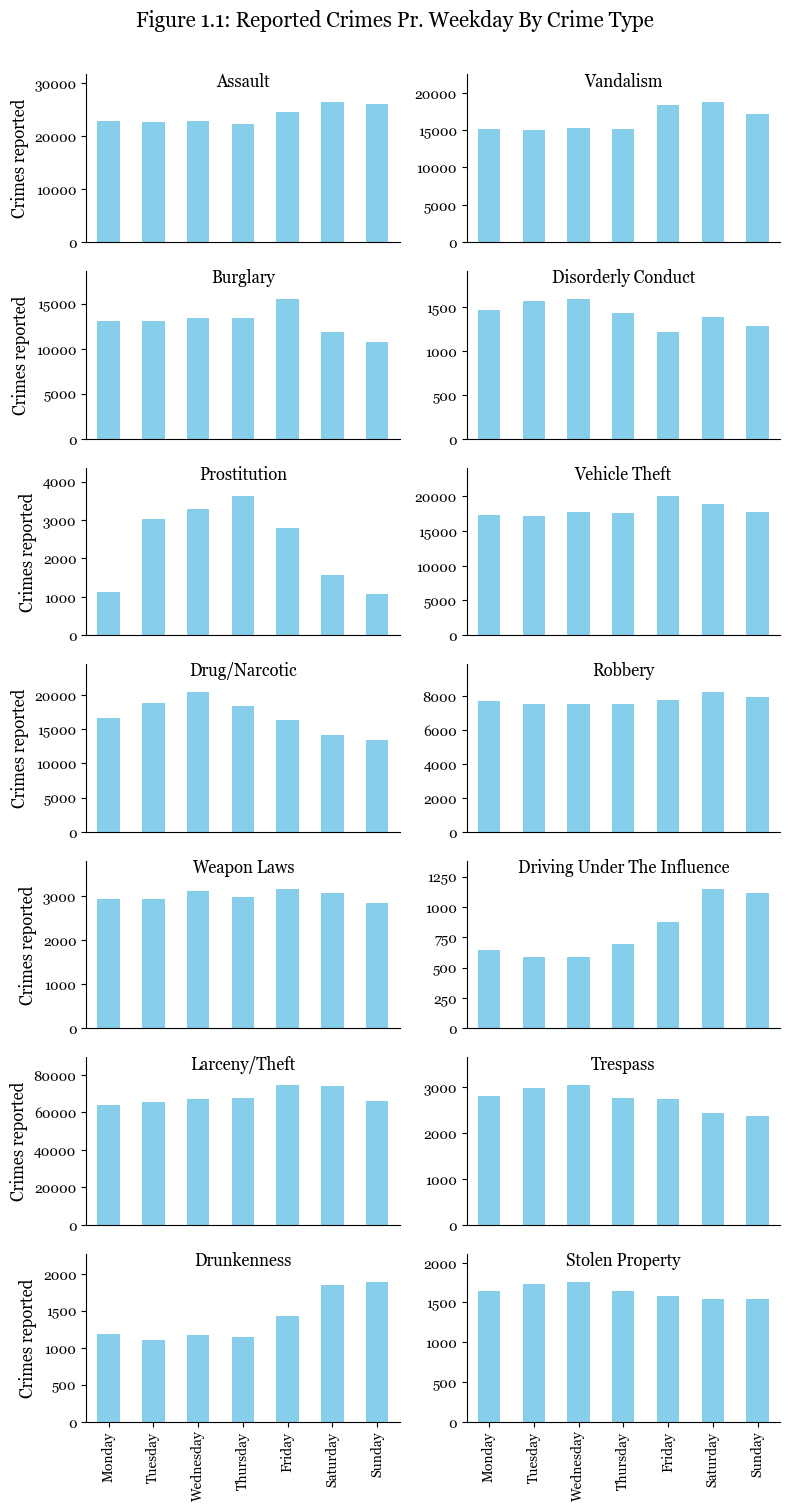

In [5]:
plot_reports_in_periods(report_data, 
                        period_col = "Weekday", 
                        xtick_order = weekday_order, 
                        x_label = None, 
                        title = "Figure 1.1: Reported crimes pr. weekday by crime type".title(), 
                        n_fig_rows = 7, 
                        n_fig_cols = 2,
                        figsize = (8, 15))

***Comment on Weekday plot:***

The plots presented above depict the reported prevalence of each of the 14 focus crimes distributed across the 7 days weekdays, providing insight into their weekly patterns. The majority of the crime types display very little variation throughout the week, e.g. `Weapon laws, Robbery, Assault`, etc. However, some types of criminality exibit clear patterns of prevalence with regard to the day of the week. For instance, `Driving under the influence` and `Drunkenness` are most prevalent on Fridays and Saturdays, coinciding with the weekend, where alcohol consumption is likely to be highest. Conversely, the prevalence of `Prostitution` is highest on Tuesdays, Wednesdays and Thursdays. The explanation for this is less obvious. Maybe this relatively high rate of prostitution around the middle of the working-week could be because people feel more lonely in the weekdays than in the weekends. Another explanation could be, that it is a matter of police resources. As mentioned, we see an increase in criminal activity relating to  `Driving under the influence` and `Drunkenness` during the weekend. Maybe the police prioritize their resources on alchohol related incidents, rather than `Prostitution` during that time. Further investigation would be needed to explain this finding. Finally, we also notice the `Drugs/Narcotic` is also most prevalent around the middle of the working-week, i.e. Tuesday, Wednesday, and Thursday. Once again, it is difficult to tell exactly why this pattern emerges, and further studies would be need to get a better understanding of this. 

Note: We excluded the xlabel, as we found the xticks to be self-explanatory.

***Month plot:***

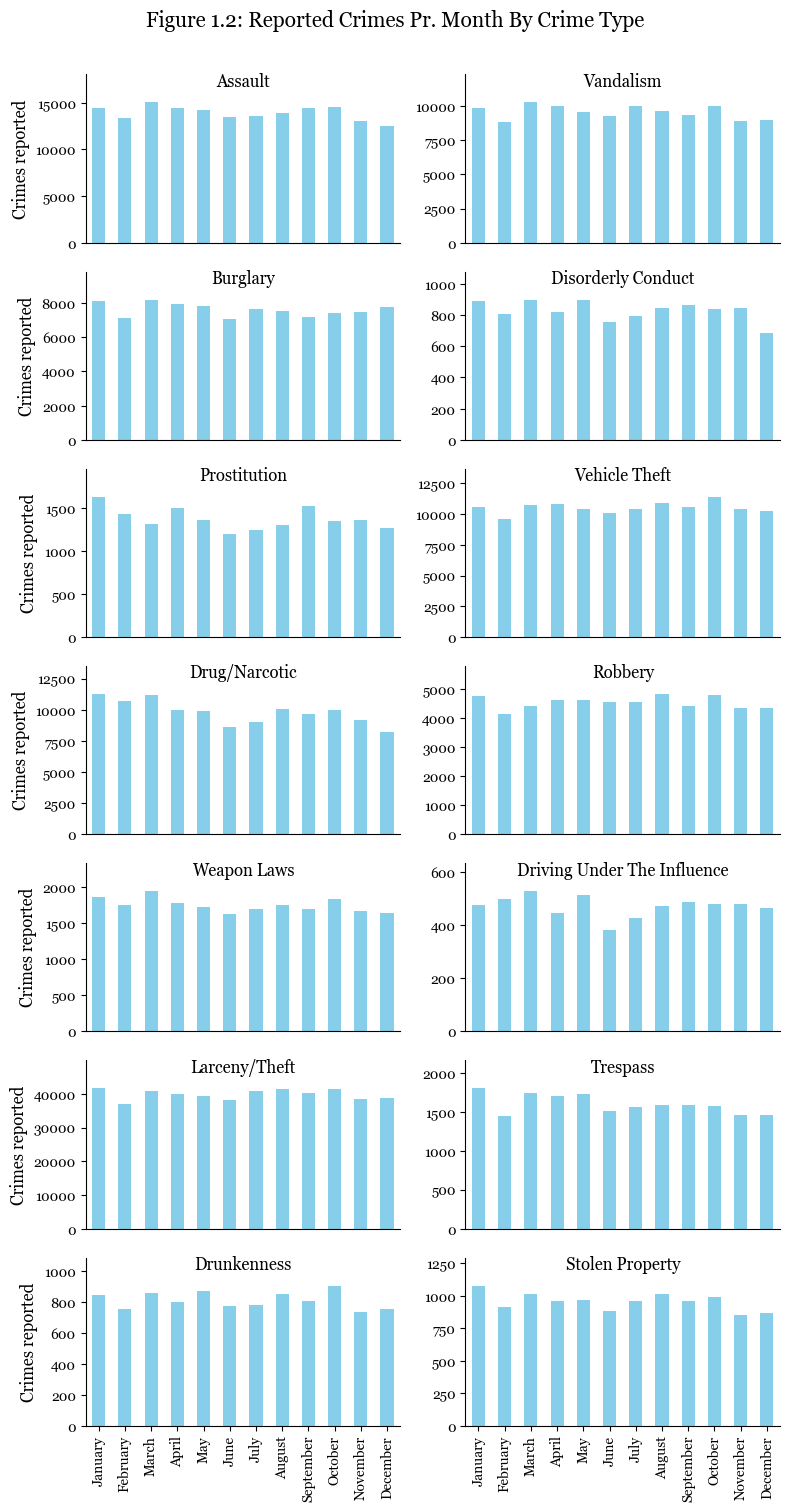

In [6]:
plot_reports_in_periods(report_data, 
                        period_col = "Month", 
                        xtick_order = month_order, 
                        x_label = None, 
                        title = "Figure 1.2: Reported crimes pr. month by crime type".title(), 
                        n_fig_rows = 7, 
                        n_fig_cols = 2,
                        figsize = (8, 15))

***Comment on Month plot:***

The plots presented above depict the reported prevalence of each of the 14 focus crimes distributed across the 12 months of the year, providing insight into their monthly patterns. Across all types of criminality, it appears that December has generaly fewer occurances of crime, compared to the rest of the months. We consider two possible explanations for this pattern. One explanation could simply be, that people are less likely to engage in criminal activities during the Christmas holiday season. Alternatively, the pattern could be explained by a decrease in police presence in December, due to either holiday-related assignments or because there are fewer officers on duty as they celebrate Christmas with their families. Further research on this may provide valuable insights into the factors that influence criminal behavior and law enforcements efforts. 

Note: We excluded the xlabel, as we found the xticks to be self-explanatory.

***Hour of the Day plot:***

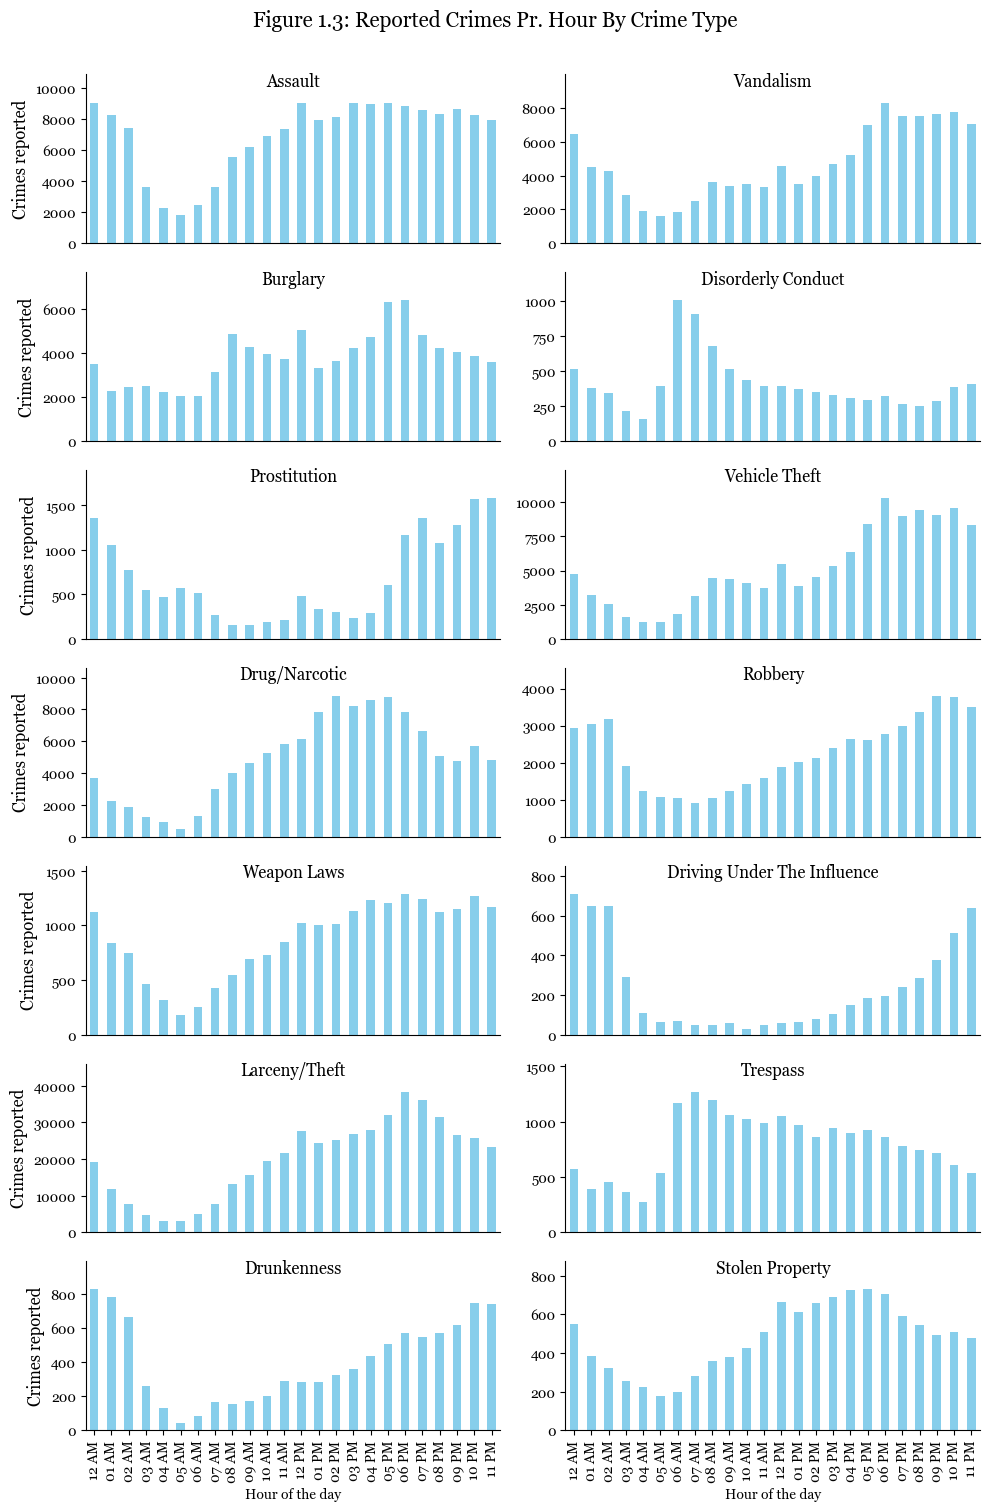

In [7]:
plot_reports_in_periods(report_data, 
                        period_col = "AM_PM_hours", 
                        xtick_order = hour_order, 
                        x_label = "Hour of the day", 
                        title = "Figure 1.3: Reported crimes pr. hour by crime type".title(), 
                        n_fig_rows = 7, 
                        n_fig_cols = 2,
                        figsize = (10, 15))

***Comment on Hour of the Day plot:***

The plots presented above depict the reported prevalence of each of the 14 focus crimes distributed across the 24 hours of the day, providing insight into their daily patterns. Across several of the crime types, the prevalence is lowest during the night and in the very early morning hours. This pattern is evident for offenses such as `Assault, Weapon Laws, Larceny/Theft, and Drug/Narcotic-related`. This is quite reasonable, as most people - i.e. those who commit the crimes or whom the crimes would be commited against - are asleep. `Driving under the influence` also exhibits a different pattern, as it almost exclusively occurs late at night and hardly ever occurs during the day time. Where many crime types are most prevalent in the evening or in the early night hours, we notice that `Trespass` occurs mostly in the morning, aroung `6/7AM`. To be honest, we don't know why. Maybe it is caused by people who sleep illegaly on other people's property, which is then discovered in the early morning hours.

Once again, further exploration of these trends could provide valuable insights into the temporal patterns of criminal activity and could help inform law enforcement efforts accordingly.

***Hour of the Week plot:***

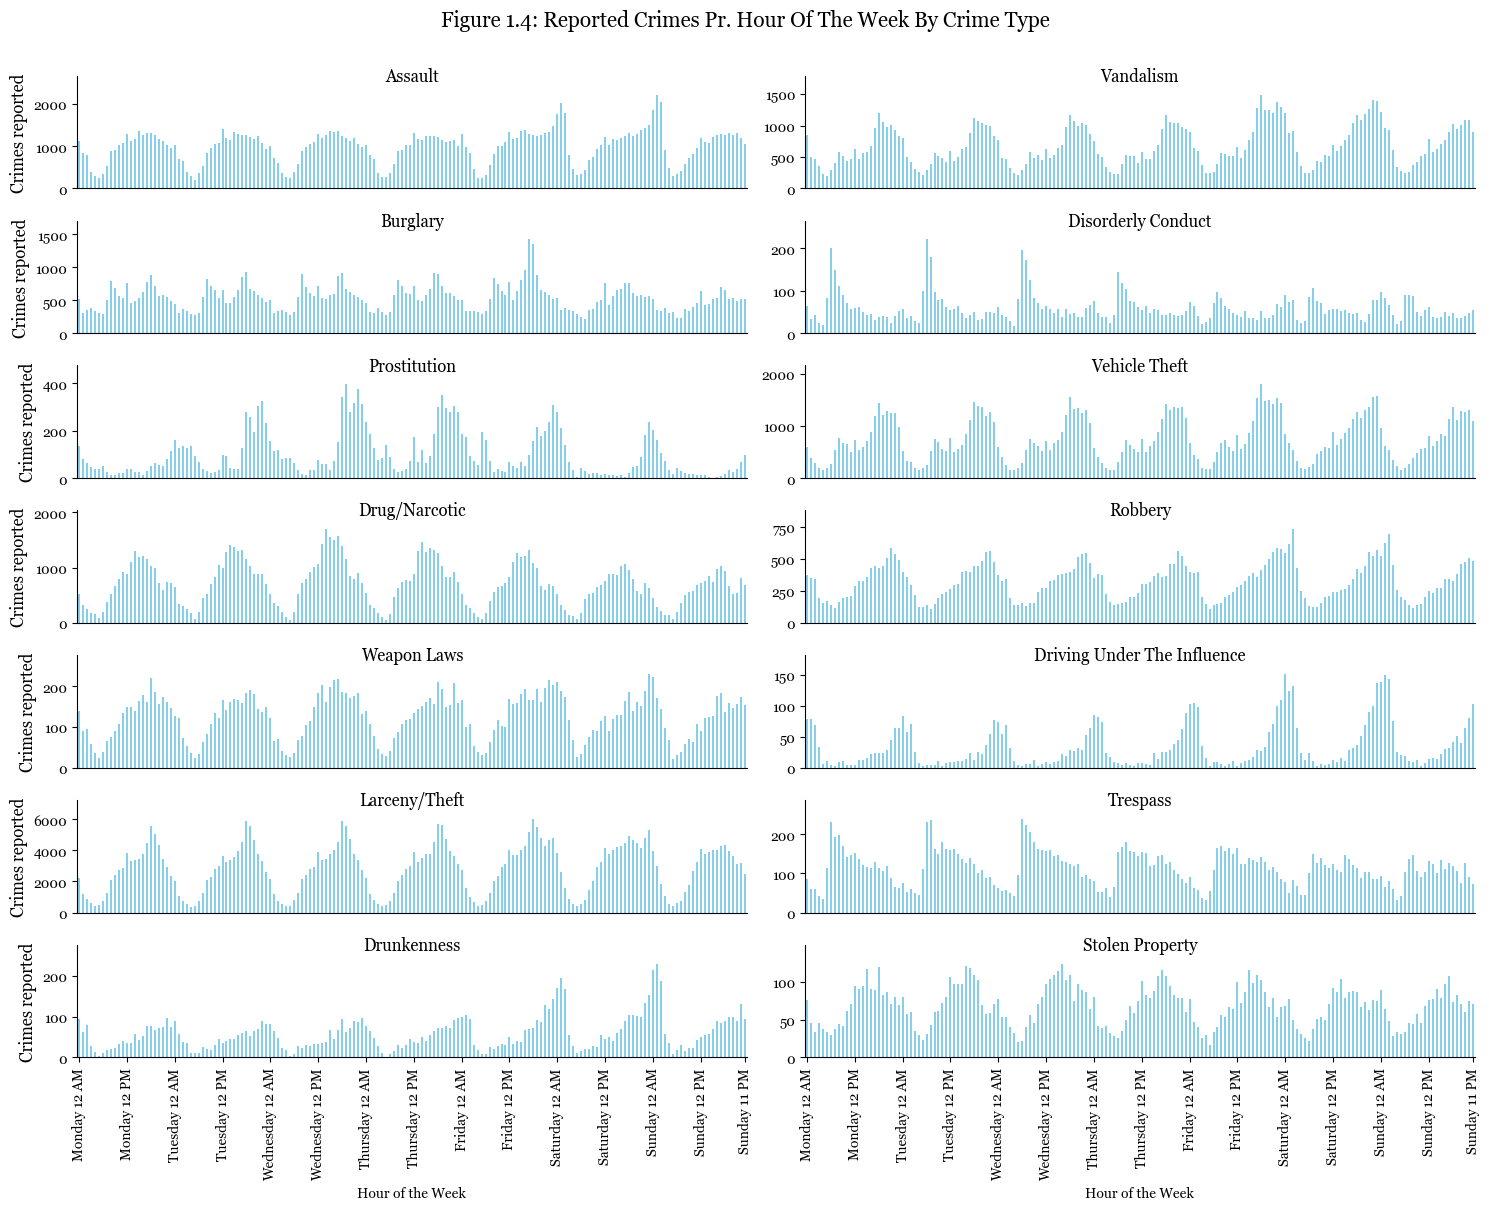

In [8]:
plot_reports_in_periods(report_data, 
                        period_col = "Weekday_Hour", 
                        xtick_order = weekday_hour_order, 
                        x_label = "Hour of the Week", 
                        title = "Figure 1.4: Reported crimes pr. hour of the week by crime type".title(), 
                        n_fig_rows = 7, 
                        n_fig_cols = 2,
                        figsize = (15, 12),
                        costum_xticks_label = custom_xticks_weekday_hour_label,
                        costum_xticks_position = custom_xticks_weekday_hour_position)

***Comment on Hours of the Week plot:***

The plots presented above depict the reported prevalence of each of the 14 focus crimes distributed across the 168 hours of the week, providing additional insights into both the daily and weekly patterns. Notice that we have not included all the combinations of hours and weekdays in the x-ticks, as that would greatly clutter the appearance of the plot. Instead, we have only labelled Midnight and Midday for each weekday. 

We see that `Assault` has the same daily pattern throughout the week, aside from Friday and Saturday around midnight, where it is much more prevalent. This probably has to do with the increased alcohol consumption during weekends, which can lead to fights. Problems associated with higher alchohol consumpted during the weekend is also displayed in `Drunkness` and `Driving Under The Influence`, where both also peak in reported prevalence on Friday and Saturday around midnight.

### **Question 1.2:** Next choose a crime type that you like and create a calendar plot (Week 2, Part 4). Don't forget to comment on patterns you observe.

Subset the data based on crime type and years, count the reports on each date and plot as a calender plot.

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


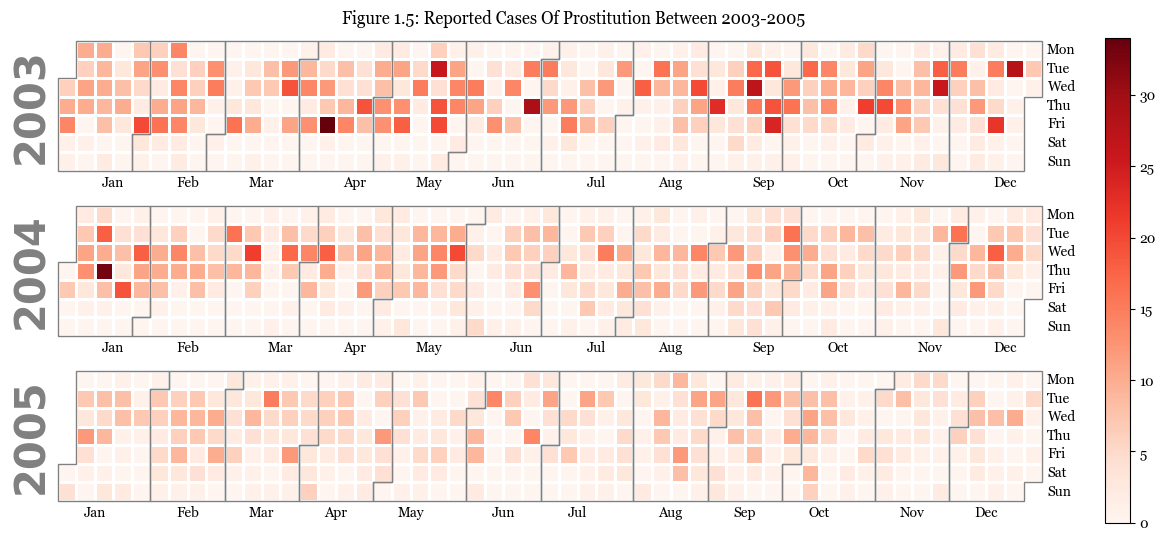

In [9]:
crime_type = "PROSTITUTION"

reports_per_date = report_data.query("Year <= 2005").\
                   query(f"Category == '{crime_type}'").groupby("Date").Category.count()


# There were no report on prostitution on 2005-12-31 --> Concat date without reports 
date_with_no_reports = pd.Series([0], index = [pd.to_datetime("2005-12-31", format = "%Y-%m-%d")])
reports_per_date = pd.concat([reports_per_date, date_with_no_reports])

calplot.calplot(reports_per_date, 
                cmap="Reds", 
                suptitle='Figure 1.5: Reported cases of prostitution between 2003-2005'.title(), 
                colorbar=True)

plt.show()

### **Answer 1.2:**

The calendar plot displays the daily number of reports on prostitution throughout the years 2003, 2004, and 2005.

We observe many of the same patterns as in Question 1.1, i.e. that prostitution is most prevalent on Tuesday, Wednesday and Thursday.

Overall, it appears as if prostitution was generally more prevalent in 2003 compared to 2004 and 2005. Two days stand out as having a particularly higher amount of reports - namely a Thursday in January 2004 and a Friday in April 2003. This might be because police operations/raids targeting prostitution were executed on these days. But that would be anyone's guess. 

### **Question 1.3:**  Finally, choose a different crime type and create a polar plot of its 24hour cycle (Week 2, Part 4). Again, don't forget to comment as you would in a figure text.

In [10]:
crime_type = "DRIVING UNDER THE INFLUENCE"

reports_by_hour = report_data.query(f"Category == '{crime_type}'").value_counts("AM_PM_hours").reindex(hour_order).reset_index()
reports_by_hour.columns = ["Hour", "Reports"]

fig = px.scatter_polar(reports_by_hour, r="Reports", theta="Hour")

fig.update_traces(fill='toself')

fig.update_layout(
    title={
        'text': "Figure 1.6: Reported cases of driving under the influence throughout the day".title(),
        'x':0.01,
        "font_size" : 16
        },
        paper_bgcolor = "rgb(223, 223, 223)",
        font_family="Georgia"
        )

fig.show()

### **Answer 1.3:**

The polar plot represents the number of reported cases of `Driving under the influence` distributed on the hours of the day. You can clearly tell from the plot, that the reported occurances of `Driving under the influence` are most prevalent in the hours around midnight. The data suggests that the police could consider focusing their efforts on `Driving under the influence` during these hours and then concentrate on other types of crimes during the daytime. However, it is possible that the reason why the data is so concentrated around midnight is because the police are already prioritizing enforcement during those hours. One could suspect that there are still drunk drivers in the morning, but police are not actively looking for them at that time.

## A1 Part 2: Dataviz questions 

Have a look at the encoding dataviz lecture (Week 4), then answer the following questions in your own words. 

* Mention 10 examples of ways we can encode data.
* Are all encodings created equally? Why not? Can you think of an example from the previous lectures?
* Mention 3 encodings that are difficult for the human eye to parse. Can you find an example of a visualization online that uses one of those three?
* Explain in your own words: What is the problem with pie-charts?

### **Question 2.1:** Mention 10 examples of ways we can encode data.

### **Answer 2.1:**

By encoding data, scientists hope to unveil patterns in the data easily and comprehensively. Here are 10 examples of encoding data:

1. `Position`: One can map longitude and lattitude onto a position on a map. 

2. `Length`: One can encode a list of numbers into the lenght of the bars in a barplot. 

3. `Area`: One can encode the values associated with a categorical variable as the percentage area in for instance a treemap.

4. `Shape`: One can give different shapes to the datapoints in e.g. a scatterplot, to illustrate a qualitative difference between datapoints - for example women having one shape and men having another shape. 

5. `Color`: One can use colorschemes/-gradients in e.g. Chrorpleth maps to show the difference between data values. 

6. `Angle`: One can encode the values associated with a categorical variable as angles in a piechart, to show the relative contribution of each category to the total. 

7. `Edge/Line weight`: One can encode data values as edge weights (visualised as line width) in a network to show the strength of the relations between nodes.  

8. `Line ending`: One can use line ending encodings to indicate the direction of a relation/edge in a network - an arrow at one end of an edge but not at the other end, would then indicate some one-way relation. 

9. `Texture`: One can encode categorical data as texture - for instance to indicate a qualitative difference between each bar in a barchart.  

10. `Pattern`: As an alternative to the `Color` encoding, one can use patterns to show the differnece between data values on e.g. a map. This is especially useful for [colorblind people](https://wearecolorblind.com/resources/textures-js-patterns-for-data-visualization/).   


### **Question 2.2:** Are all encodings created equally? Why not? Can you think of an example from the previous lectures?

### **Answer 2.2:**

In his video, Sune highlights the pie chart as an example of a less desirable encodings. He argues that encodings should make data more interpretable, which is less succesfully achived with encodings such as area, angles or color intensity.

An example of a potentially problematic encoding from the previous lecture could be when we used color intensity to examine and compare the prevalence of `vehicle theft` within different neighborhoods in San Francisco (which we will also do in Part 3 of this assignment). Eventhough choropleth maps can give a nice geographical indication of a given distribution, color intensity encodings have a certain degree of inaccuracy to them. 

### **Question 2.3:**  Mention 3 encodings that are difficult for the human eye to parse. Can you find an example of a visualization online that uses one of those three?

### **Answer 2.3:**

Sune mentions three encodings that are difficult for the human eye to parse: 

1. `Angle` 

2. `Area/size` 

3. `Color Intensity`

All of the above have indicative qualities, but are not very well suited for accurate comparisons. Below is an example of a visualization that uses both `Angle` and `Area`, making the whole graph quite unreadable.


<p align="center">
<img src="https://images.squarespace-cdn.com/content/v1/57cefb6937c581cd57227a93/6a83f745-06c3-4c33-adf5-e85d0f432526/Screenshot+2021-10-27+11.08.49+AM.png?format=750w">

### **Question 2.4:**  Explain in your own words: What is the problem with pie-charts?

### **Answer 2.4:**

Below is an example with 3 pie charts, illustrating how difficult it can be to percieve and compare data points, when encoded as a pie chart (area/angle). For each pie chart, there is a bar plot to demonstrate how much easier it is to process the data through a different encoding, i.e. through the length of a rectangle.

<p align="center">
<img src="https://miro.medium.com/v2/resize:fit:828/0*G2cCRFPqLl7vtgr9.">
<p>

Looking only at the pie charts, one can kind of tell that they are not necesarily equally sized in A and C, but it is quite hard to tell the exact difference in magnitude. Looking at the bar plots however, it is easier to percieve and compare. 

## A1 Part 3: Visualizing geodata using Plotly

In this sub-assignment I want you to create a choropleth map of San Francisco, showing where it's safest to leave your car on Sundays, following the instructions from Week 3.

When you're done, reflect on the following questions.

* Based on your map and analysis, where should you park the car for it to be safest on a Sunday? And where's the worst place?
* Using visualizations can help us uncover powerful data-patterns. However, when designing visualizations, we need to be aware of several illusions that can lead viewers to misinterpret the data we are showing (i.e. perceptual errors):
   - Try to change the range of data-values in the plot above. Is there a way to make the difference between district less evident?
   - Why do you think perceptual errors are a problem? Try to think of a few examples. 

### **Question 3.1:** In this sub-assignment I want you to create a choropleth map of San Francisco, showing where it's safest to leave your car on Sundays, following the instructions from Week 3.

Load and process data

In [11]:
# Load shapefile
shape_file = requests.get("https://raw.githubusercontent.com/suneman/socialdata2022/main/files/sfpd.geojson").json()
# Subset crime data and count occurances by district 
vehicle_theft_sunday_data = report_data.query("Category == 'VEHICLE THEFT' and DayOfWeek == 'Sunday'")
vehicle_theft_sunday_by_district = vehicle_theft_sunday_data.PdDistrict.value_counts().reset_index()
vehicle_theft_sunday_by_district.columns = ["District", "reported_crimes"]

Plot choropleth map based on reported vehicle theft distributed into districts 

In [12]:
max_color_range = vehicle_theft_sunday_by_district.reported_crimes.max()

fig = px.choropleth_mapbox(vehicle_theft_sunday_by_district,
                           geojson=shape_file,
                           locations='District',
                           color='reported_crimes',
                           color_continuous_scale="ylorbr",
                           range_color=(0, max_color_range),
                           mapbox_style="carto-positron",
                           zoom = 10.9, 
                           center = {"lat": 37.771, "lon": -122.4256},
                           opacity=0.5,
                           labels={'reported_crimes':'Reported Vehicle Theft'}
                          )


fig.update_layout(
    title={
        'text': "Figure 3.1: Reported Cases of Vehicle Theft by District",
        'y':0.98,
        'x':0.01,
        "font_size" : 16
        },
        font_family="Georgia"
        )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

### **Question 3.2:** Based on your map and analysis, where should you park the car for it to be safest on a Sunday? And where's the worst place?


### **Answer 3.2:** 

The immidiate impression is, that `Tenderloin` is the best place to park your car, while `Ingleside` is the most risky district. However, `Tenderloin` is a substantially smaller area than the remaining districts, so it could be relevant to also account for how big/populated the districts are. Furthermore, `Tenderloin` appears to be more centrally placed then `Ingleside`, which could mean that there aren't as many parking spots there, as in the city fringe. Thus, it might simply come down to how many cars there are available for stealing in the given districts. 

### **Question 3.3:** Using visualizations can help us uncover powerful data-patterns. However, when designing visualizations, we need to be aware of several illusions that can lead viewers to misinterpret the data we are showing (i.e. perceptual errors):
   - #### **Question 3.3.1**: Try to change the range of data-values in the plot above. Is there a way to make the difference between district less evident?

We raise the maximum value in the data-values range and plot again

In [13]:
max_color_range = 50_000

fig = px.choropleth_mapbox(vehicle_theft_sunday_by_district,
                           geojson=shape_file,
                           locations='District',
                           color='reported_crimes',
                           color_continuous_scale="ylorbr",
                           range_color=(0, max_color_range),
                           mapbox_style="carto-positron",
                           zoom = 10.9, 
                           center = {"lat": 37.771, "lon": -122.4256},
                           opacity=0.5,
                           labels={'reported_crimes':'Reported Vehicle Theft'}
                          )

fig.update_layout(
    title={
        'text': "Figure 3.2: Reported Cases of Vehicle Theft by District",
        'y':0.98,
        'x':0.01,
        "font_size" : 16
        },
        font_family="Georgia"
        )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### **Answer 3.3.1:**

An obvious way of introducing a perceptual error into the plot, would be by raising the maximum value in the range of data-values, thus making the relative differences between the districts seem smaller or even non-existing. We have chosen to raise the maximum value to 50.000. Given that range, the districts appear to be exactly alike with regard to the prevalence of `Vehicle Theft`.

   - #### **Question 3.3.2**: Why do you think perceptual errors are a problem? Try to think of a few examples. 

### **Answer 3.3.2:**

Perceptual errors are obviously a problem, as they entail the inability to interpret our data in a fair and accurate manner, which in turn leads us to false, misinformed conclusions. If they are actively utilized by evil minds, they can be used to push personal or political agendas under the guise of facticity and truth, as also demonstrated in the [article](https://www.businessinsider.com/fox-news-obamacare-chart-2014-3?r=US&IR=T).

There are many examples of perceptual errors, such as bias and prejudice. Crime statistics is a prime example of something that can easily appear to be factual, while actually being very much in danger of suffering from perceptual errors. Measuring crime is a complex task, as official records are often incomplete or biased. Scientists have used surveys to reveal that not all crimes are reported to the police, and that some types of crime are less likely to be reported than others, thus making it difficult to measure the actual amount of criminal conduct (Andresen, 2019). Another source of bias in crime data is that some ethnic groups in the USA have a higher likelihood of being reported than others (Baumer & Lauritsen, 2010:166ff).

## A1 Part 4: Errors in the data

We started the course by plotting simple histogram and bar plots that showed a lot of cool patterns. But sometimes the binning can hide imprecision, irregularity, and simple errors in the data that could be misleading. In the work we've done so far, we've already come across at least three examples of this in the SF data (listed in Part 3 of Week 4). 

The data errors we discovered at the end of Week 4 become difficult to notice when we aggregate data (and when we calculate mean values, as well as statistics more generally). Thus, when we visualize, errors become difficult to notice when binning the data. We explore this process in the exercise below.

* In each of the 3 examples we listed during Week 4, describe in your own words how the data-errors I call attention to above can bias the binned versions of the data. 
* Also, briefly mention how not noticing these errors can result in misconceptions about the underlying patterns of what's going on in San Francisco (and our modeling).
* Find your own example of human noise in the data and visualize it.

### **Question 4.1:** In each of the 3 examples we listed during Week 4, describe in your own words how the data-errors I call attention to above can bias the binned versions of the data. Also, briefly mention how not noticing these errors can result in misconceptions about the underlying patterns of what's going on in San Francisco (and our modeling).
   - ### **Example 1**: In the temporal activity for `PROSTITUTION` something surprising is going on on Thursday. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/prostitution.png), where I've highlighted the phenomenon I'm talking about.

### **Answer to Example 1:**
Looking into the data we find that 26% of the reported cases on `Prostitution` are duplicated observations on Thursday. Looking further into the issue with duplicate observations, we find that there are quite a few duplicated reports on `Prostitution` on all the other weekdays as well. In the barplot below, we have removed all the duplicate observations on `Prostitution` and plotted these beside the duplicated data. We find, that even though we remove all the duplicates, it does not change the overall pattern of Tuesday, Wednesday and Thursday being the days with most reports on `Prostitution`.

If one does not adequatly addresse or handle duplicate observations, these can bias the data (and our subsequent conclusions) and trick us into thinking that `Prostitution` is more prevalent on particular days, when it actually simply is a matter of a somewhat messy dataset.

In [17]:
# Subset Category and split into w/without duplicates
prost_w_dup = report_data.query(f"Category == 'PROSTITUTION'").copy()
prost_no_dup = prost_w_dup.drop_duplicates().copy()

# Only thursdat
prost_w_dup_thursday = prost_w_dup.query("Weekday == 'Thursday'") 
prost_no_dup_thursday = prost_no_dup.query("Weekday == 'Thursday'")

# Descriptive stats
diff_with_and_without_dups = prost_w_dup_thursday.shape[0] - prost_no_dup_thursday.shape[0]
percentage_duplicates = ((diff_with_and_without_dups)/prost_w_dup_thursday.shape[0])*100

print(f"Number of duplicate values in prostitution on Thursdays: {diff_with_and_without_dups} ({percentage_duplicates:.2f}%)")

#Count by weekday
prost_w_dup_count_by_weekday = prost_w_dup.groupby("Weekday").IncidntNum.count().reindex(weekday_order).rename("Count").reset_index() 
prost_no_dup_count_by_weekday = prost_no_dup.groupby("Weekday").IncidntNum.count().reindex(weekday_order).rename("Count").reset_index()

# Add w/without duplicates label
prost_w_dup_count_by_weekday["Duplicated"] = "Reports with duplicates"
prost_no_dup_count_by_weekday["Duplicated"] = "Reports without duplicates"

# Concat
prost_count_by_weekday = pd.concat([prost_w_dup_count_by_weekday, prost_no_dup_count_by_weekday])

Number of duplicate values in prostitution on Thursdays: 958 (26.35%)


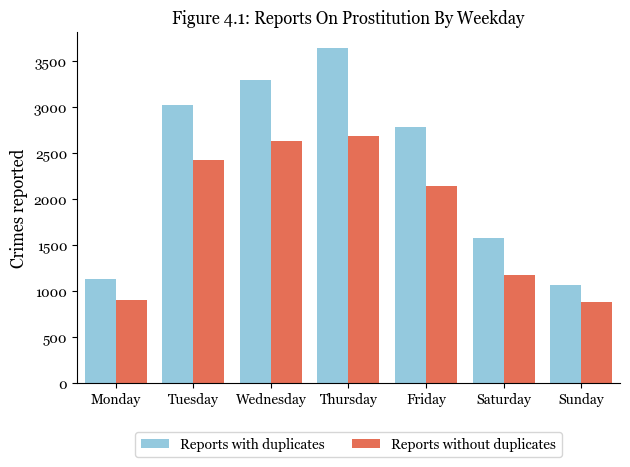

In [15]:
fig, ax = plt.subplots()

sns.barplot(data = prost_count_by_weekday,
            x = "Weekday", 
            y = "Count", 
            hue = "Duplicated", 
            palette = ["skyblue","#FD603E"],
            ax = ax)

ax.set_ylabel("Crimes reported", size = 12)
ax.set_xlabel("")
ax.set_title(label = "Figure 4.1: Reports on Prostitution by Weekday".title(), size = 12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove title from the legend and place below plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[2:], 
          labels=labels[2:], 
          loc='upper center', 
          bbox_to_anchor=(0.5, -0.12),
          ncols = 2)

plt.tight_layout()
plt.show()

   - ### **Example 2**: Last week, when we investigated the details of how the timestamps are recorded using jitter-plots in the DAOST exercises, we saw that many more crimes were recorded e.g. on the hour, 15 minutes past the hour, and to a lesser in whole increments of 10 minutes. Crimes didn't appear to be recorded as frequently in between those round numbers. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/jitter.png), where I've highlighted the phenomenon I'm talking about.

### **Answer to Example 2:**

As mentioned in `Example 2`, when we plotted the distribution of reported crimes based on their time of reporting, we found that the reported times tended to happen on what one could call "round timestamps", e.g. exactly on the hour, half past, 15 minutes past, etc. If one were to trust blindly in the data, one could then be inclined to think that crimes happen most often at these "even" minutes of the hour, i.e. that the prevalence of criminal activity correlates with the minut of the hour. Following this line of thought, one could be mislead to advice the police to focus their resources on these "round timestamps". We, however, suspect this pattern to be caused by the policemen rounding up or down to a more even timestamp, rather than noting the actual, exact timestamps, out of convenience.



   - ### **Example 3**: Also, the *Hall of Justice* on the 800 block of Bryant street seems to be an unlikely hotspot for sex offences. Take a look here [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/crime_hot_spot.png).

### **Answer to Example 3:** 

As `Example 3` states, the heatmap displays that the area around the Hall of Justice appears to be a popular location for sex offences. Looking into this, we find that the Hall of Justice is adjacent to the San Francisco Police Department. It seems unlikly that the police station is a hotspot for sex offences, and we therefore suspect that there are some issues with the recording of the data. A possible explanation for this could be that when victims of a sexual offence come to the police station to report the incident, but either can't or won't provide a specific location for the offense, the location of the police station is simply recorded. 

Once again, if we were to blindly and uncritically trust the data, one could have been mislead into advicing the police to focus on their own station in order to thwart the prevalence of sex offences. That would be both awkward and a false conclusion (hopefully).

### **Question 4.2:** Find your own example of human noise in the data and visualize it.

As a demonstration of a potential source of human noise in the data, we have chosen to take a closer look at the amount of reported crimes around Christmas time. 


In Question 1.1, we found that December in general has a lower crime rate. We have a suspicion that this is a result of Christmas vacation and the holidays on the 24th and the 25th. We will therefore visualize the crime rates in December, and see if we find any irregularities. Using the plot function from A1 Part 1 (`plot_reports_in_periods`), we can easily plot the data of December for at closer look.   


Below, we plot the number of reports for each of the 14 focus crimes distributed on the days in December. 

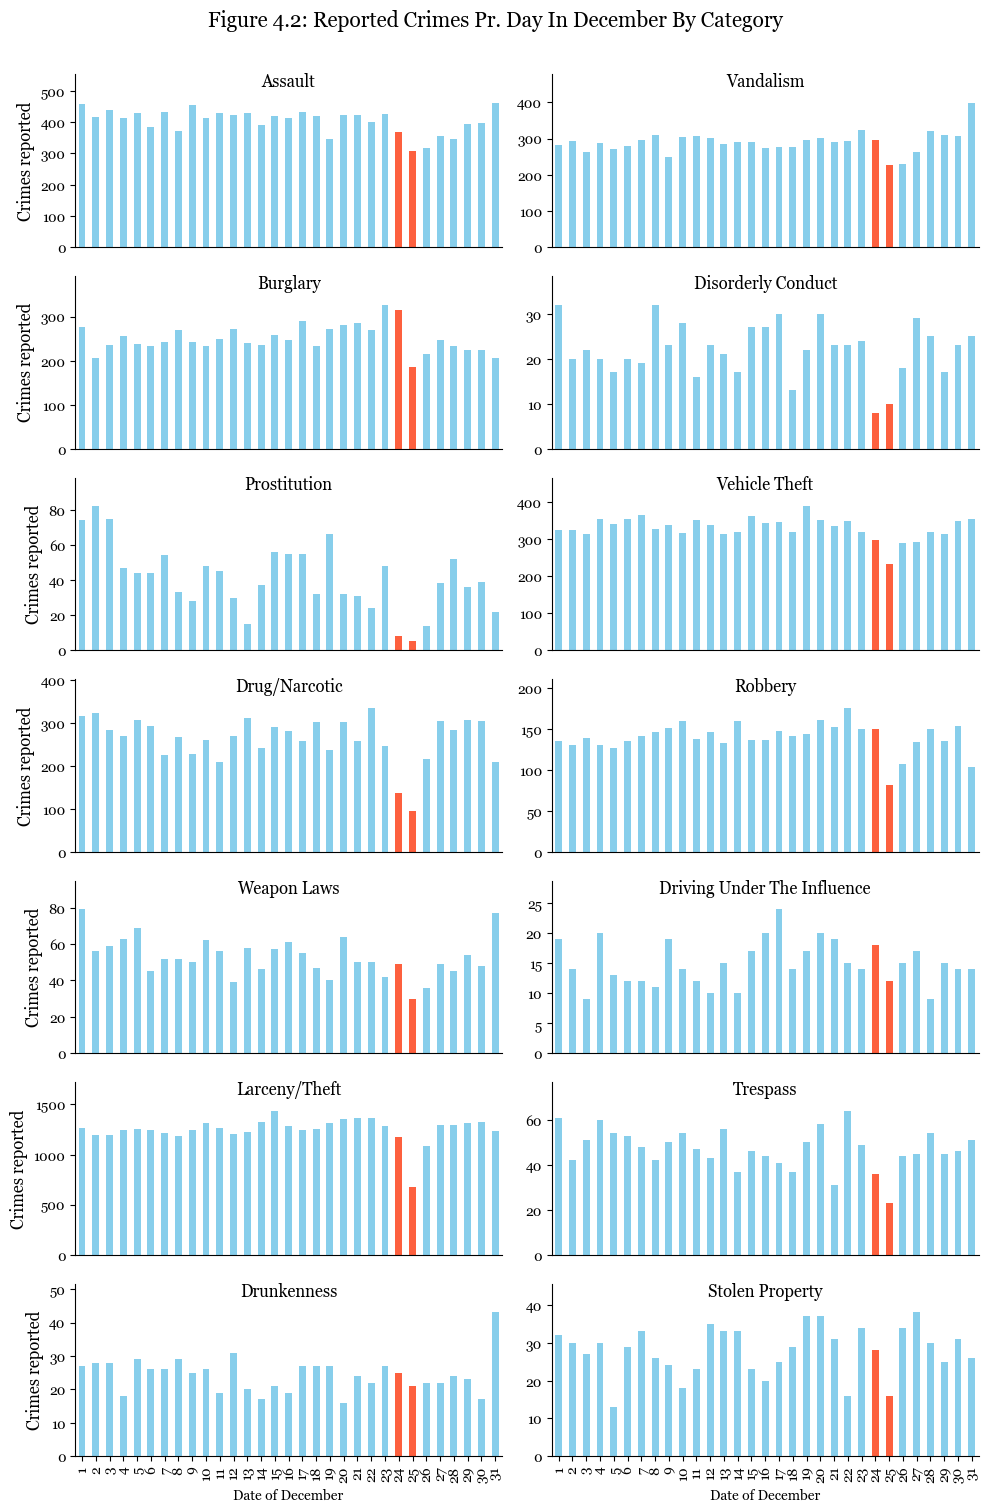

In [16]:
# Subset data and convert date to date of the month 
reports_in_december = report_data[report_data["Month"]=="December"].copy()
reports_in_december["Date_of_month"] = reports_in_december["Date"].dt.day
date_of_month = range(1,32)

plot_reports_in_periods(reports_in_december, 
                        period_col = "Date_of_month", 
                        xtick_order= date_of_month, 
                        x_label = "Date of December", 
                        title = "Figure 4.2: Reported crimes pr. day in December by category".title(), 
                        n_fig_rows = 7, 
                        n_fig_cols = 2,
                        figsize = (10,15),
                        idx_of_bars_to_change_color=[23,24])

### **Answer 4.2:** 

In the above plots, it is apparent that nearly all the crime types have the least amount of activity on the 24th and the 25th of December. The two exceptions to this rule is `Drunkennes` and `Driving under influence`. A conclusion to this would be that criminal activity in San Francisco is drastically less prevalent on Christmas - especially on the 25th. 


However, this conclusion is not exactly in line with other analyses regarding the prevalence of criminal activity around Christmas time. For instance, one analysis states that crimes like `Larcency Theft` and `Burglary` are actually more prevalent during the holidays (ABC 2022). 

Therefore we think our results could be an example of bias and human noise in the data. One explanation for the lower crime rates in San Francisco during the Holidays, could be that the police force of San Francisco is understaffed during the Christmas days, when most of the officers are off-duty, celebrating Christmas with their families (SFGATE 2015 & San Francisco Examiner 2020). Another possible explanation for the human noise in the dataset, could be that crimes such as `Larcency/Theft`, `Burglary`, or `Vehicle Theft`, are first discovered in the days after the holidays when people return to their house after visiting family. Not knowing at exactly which time the crime took place, the reported time of the crime might just be recorded as the time the report was filled. However, this latter explanation would entail a peak in reportings in the days after Christmas, which is not the case in our data. 

# References 

- ABC 2022, "Burglaries peak during the holiday season. This is how thieves pick which house to rob", Link: https://www.abc.net.au/news/2022-12-28/christmas-holiday-season-for-your-home-to-be-burgled-keep-safe/101810282, last visited:  27/02/3023

- Andresen, Martin A. 2019. Environmental Criminology: Evolution, Theory, and Practice (2nd
ed.). Routledge. London. https://doi.org/10.4324/9780429455391

- Baumer, Eric P., and Janet L. Lauritsen. 2010. “Reporting Crime to the Police, 1973-2005: A
Multivariate Analysis of Long-Term Trends in the National Crime Survey (NCS) and National
Crime Victimization Survey (NCVS).” Criminology: An Interdisciplinary Journal 48(1):131–85.
doi: 10.1111/j.1745-9125.2010.00182.x

- San Francisco Examiner 2020, "Study finds SFPD patrol staffing 'severely inadequate'", Link: https://www.sfexaminer.com/archives/study-finds-sfpd-patrol-staffing-severely-inadequate/article_ec451de3-a872-548f-af37-ac9916d59345.html, last visited: 27/02/2023

- SFGATE 2015, "Plan to increase S.F. police staffin advances through committee", Link: https://www.sfgate.com/politics/article/Plan-to-increase-S-F-police-staffing-advances-6329285.php, last visited: 27/02/2023